# Data modelling
---
- Training - Validation - Testing split
- Adding variables
- Embedding and correcting for categorical variables with huge amounts of classes (the variable "Store")
- Random forests, XGBoost
- Neural networks, LSTMs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
import warnings

In [2]:
dataset = pd.read_pickle("train_clean.pkl")
dataset.head(3)

,Sales,Customers,Store,Date,DayOfWeek,Week,Month,Year,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,LogCompetitionDistance,CompetitionMonthsKnown,CompetitionMonthsTotal,Promo2,Promo2MonthsTotal,Promo2CurrentlyOn
0,5263,555,1,2015-07-31,5,31,7,2015,1,1,0,1,c,a,7.146772,1,82,0,0.00,0
1,6064,625,2,2015-07-31,5,31,7,2015,1,1,0,1,a,a,6.345636,1,92,1,64.50,1
2,8314,821,3,2015-07-31,5,31,7,2015,1,1,0,1,a,a,9.556055,1,103,1,52.25,1


In [3]:
### Split the dataset into 3 disjunct sets
days_amount = (dataset.Date.iloc[0,] - dataset.Date.iloc[-1,])
print("The entire dataset is", days_amount.days, "days long")

# We will do 90-5-5 split to align with the original kaggle prediction expectations

# Gets the last date information and goes back around 5% of the dataset (the -1 corrects from sunday to monday)
test_split_time = dataset.Date.iloc[0,] - pd.Timedelta(days=int(days_amount.days*0.05 - 1))
# Same for the validation data
validation_split_time = dataset.Date.iloc[0,] - pd.Timedelta(days=int(days_amount.days*0.1 + 1))

train_set = dataset[dataset.Date < validation_split_time]
validation_set = dataset[(dataset.Date >= validation_split_time) & (dataset.Date < test_split_time)]
test_set = dataset[dataset.Date >= test_split_time]

# Check if the division went well
display(train_set.Date.iloc[[-1,0],])
display(validation_set.Date.iloc[[-1,0],])
display(test_set.Date.iloc[[-1,0],]) # Everything looks great

The entire dataset is 941 days long


1017208   2013-01-01
107040    2015-04-26
Name: Date, dtype: datetime64[ns]

107039   2015-04-27
52405    2015-06-14
Name: Date, dtype: datetime64[ns]

52404   2015-06-15
0       2015-07-31
Name: Date, dtype: datetime64[ns]

In [4]:
# Due to autocorrelation surfacing in the visualization part, we're going to add 
# lag and rolling mean

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for df in (train_set, validation_set, test_set):
        df["SalesLag1"] = df.groupby("Store")["Sales"].shift(1)
        df["SalesLag2"] = df.groupby("Store")["Sales"].shift(2)
        df["SalesLag7"] = df.groupby("Store")["Sales"].shift(7)

        # rolling mean that takes the average from the past 3 values and DOESN'T include itself
        df["RollingMean7"] = df.groupby("Store")["Sales"].rolling(7).mean().shift(1).reset_index(level=0, drop=True)
        first_idx_per_store = df.groupby("Store").head(1).index
        df.loc[first_idx_per_store, "RollingMean7"] = float("nan")

        # NNs cannot work with NaN values (albeit Random Forests can), so we utilize simple dummies to signal if a value is empty
        df["SalesLag1Available"] = ~df["SalesLag1"].isna() * 1
        df["SalesLag2Available"] = ~df["SalesLag2"].isna() * 1
        df["SalesLag7Available"] = ~df["SalesLag7"].isna() * 1
        df["RollingMean7Available"] = ~df["RollingMean7"].isna() * 1
        # And then we transform NaNs -> 0
        df.loc[:, df.isna().sum() != 0] = df.loc[:, df.isna().sum() != 0].fillna(0)
        


In [5]:
train_set.loc[train_set.Store == 2, ["Sales", "SalesLag1Available", "SalesLag1", "SalesLag2", "SalesLag7", "RollingMean7Available", "RollingMean7"]].head(8)

,Sales,SalesLag1Available,SalesLag1,SalesLag2,SalesLag7,RollingMean7Available,RollingMean7
107041,0,0,0.0,0.0,0.0,0,0.000000
108156,2916,1,0.0,0.0,0.0,0,0.000000
109271,3678,1,2916.0,0.0,0.0,0,0.000000
110386,3588,1,3678.0,2916.0,0.0,0,0.000000
111501,5032,1,3588.0,3678.0,0.0,0,0.000000
112616,3291,1,5032.0,3588.0,0.0,0,0.000000
113731,4184,1,3291.0,5032.0,0.0,0,0.000000
114846,0,1,4184.0,3291.0,0.0,1,3241.285714


In [6]:
train_set.head(3)

,Sales,Customers,Store,Date,DayOfWeek,Week,Month,Year,Open,Promo,...,Promo2MonthsTotal,Promo2CurrentlyOn,SalesLag1,SalesLag2,SalesLag7,RollingMean7,SalesLag1Available,SalesLag2Available,SalesLag7Available,RollingMean7Available
107040,0,0,1,2015-04-26,7,17,4,2015,0,0,...,0.00,0,0.0,0.0,0.0,0.0,0,0,0,0
107041,0,0,2,2015-04-26,7,17,4,2015,0,0,...,61.00,1,0.0,0.0,0.0,0.0,0,0,0,0
107042,0,0,3,2015-04-26,7,17,4,2015,0,0,...,48.75,1,0.0,0.0,0.0,0.0,0,0,0,0


In [7]:
display(train_set["StateHoliday"].unique())

holiday_map = {"0": 0, "a": 1, "b": 2, "c": 3}
storetype_map = {"a": 0, "b": 1, "c": 2, "d": 3}
assortment_map = {"a": 0, "b": 1, "c": 2}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for df in (train_set, validation_set, test_set):
        df["StateHoliday"] = df["StateHoliday"].map(holiday_map).astype(int)
        df["StoreType"] = df["StoreType"].map(storetype_map).astype(int)
        df["Assortment"] = df["Assortment"].map(assortment_map).astype(int)

['0', 'b', 'a', 'c']
Categories (4, object): ['0', 'a', 'b', 'c']

In [8]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 910169 entries, 107040 to 1017208
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Sales                   910169 non-null  int64         
 1   Customers               910169 non-null  int64         
 2   Store                   910169 non-null  int64         
 3   Date                    910169 non-null  datetime64[ns]
 4   DayOfWeek               910169 non-null  int64         
 5   Week                    910169 non-null  int32         
 6   Month                   910169 non-null  int32         
 7   Year                    910169 non-null  int32         
 8   Open                    910169 non-null  int64         
 9   Promo                   910169 non-null  int64         
 10  StateHoliday            910169 non-null  int64         
 11  SchoolHoliday           910169 non-null  int64         
 12  StoreType               91016

## Modelling part

In [9]:
x_train = train_set.loc[:, ~train_set.columns.isin(["Sales", "Date"])]
y_train = train_set.loc[:, "Sales"]

x_val = validation_set.loc[:, ~validation_set.columns.isin(["Sales", "Date"])]
y_val = validation_set.loc[:, "Sales"]

x_test = test_set.loc[:, ~test_set.columns.isin(["Sales", "Date"])]
y_test = test_set.loc[:, "Sales"]

In [10]:
x_test.head()

,Customers,Store,DayOfWeek,Week,Month,Year,Open,Promo,StateHoliday,SchoolHoliday,...,Promo2MonthsTotal,Promo2CurrentlyOn,SalesLag1,SalesLag2,SalesLag7,RollingMean7,SalesLag1Available,SalesLag2Available,SalesLag7Available,RollingMean7Available
0,555,1,5,31,7,2015,1,1,0,1,...,0.00,0,0.0,0.0,0.0,0.0,0,0,0,0
1,625,2,5,31,7,2015,1,1,0,1,...,64.50,1,0.0,0.0,0.0,0.0,0,0,0,0
2,821,3,5,31,7,2015,1,1,0,1,...,52.25,1,0.0,0.0,0.0,0.0,0,0,0,0
3,1498,4,5,31,7,2015,1,1,0,1,...,0.00,0,0.0,0.0,0.0,0.0,0,0,0,0
4,559,5,5,31,7,2015,1,1,0,1,...,0.00,0,0.0,0.0,0.0,0.0,0,0,0,0


In [ ]:
rf = RandomForestRegressor( # trying a random assortment of hyperparameters
    n_estimators=50,
    max_depth=1000,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

In [ ]:
rf.fit(x_train, y_train)

,n_estimators,50
,criterion,'squared_error'
,max_depth,1000
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
def rmspe(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    non_zero_idx = y_true != 0
    return np.sqrt(np.mean(((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])**2))

In [ ]:
y_val_predicted = rf.predict(x_val)

mse = mean_squared_error(y_val, y_val_predicted)
rmse = mse ** 0.5
r2 = r2_score(y_val, y_val_predicted)
rmspe_val = rmspe(y_val, y_val_predicted)

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation R²: {r2:.3f}")
print(f"Validation RMSPE: {rmspe_val:.4f} ({rmspe_val*100:.2f}%)")

Validation RMSE: 944.43
Validation R²: 0.947
Validation RMSPE: 0.1558 (15.58%)


In [ ]:
y_test_predicted = rf.predict(x_test)
mse = mean_squared_error(y_test, y_test_predicted)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_test_predicted)

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation R²: {r2:.3f}")

rmspe_test = rmspe(y_test, y_test_predicted)
print(f"Validation RMSPE: {rmspe_test:.4f} ({rmspe_test*100:.2f}%)")

Validation RMSE: 1293.71
Validation R²: 0.880
Validation RMSPE: 0.1843 (18.43%)


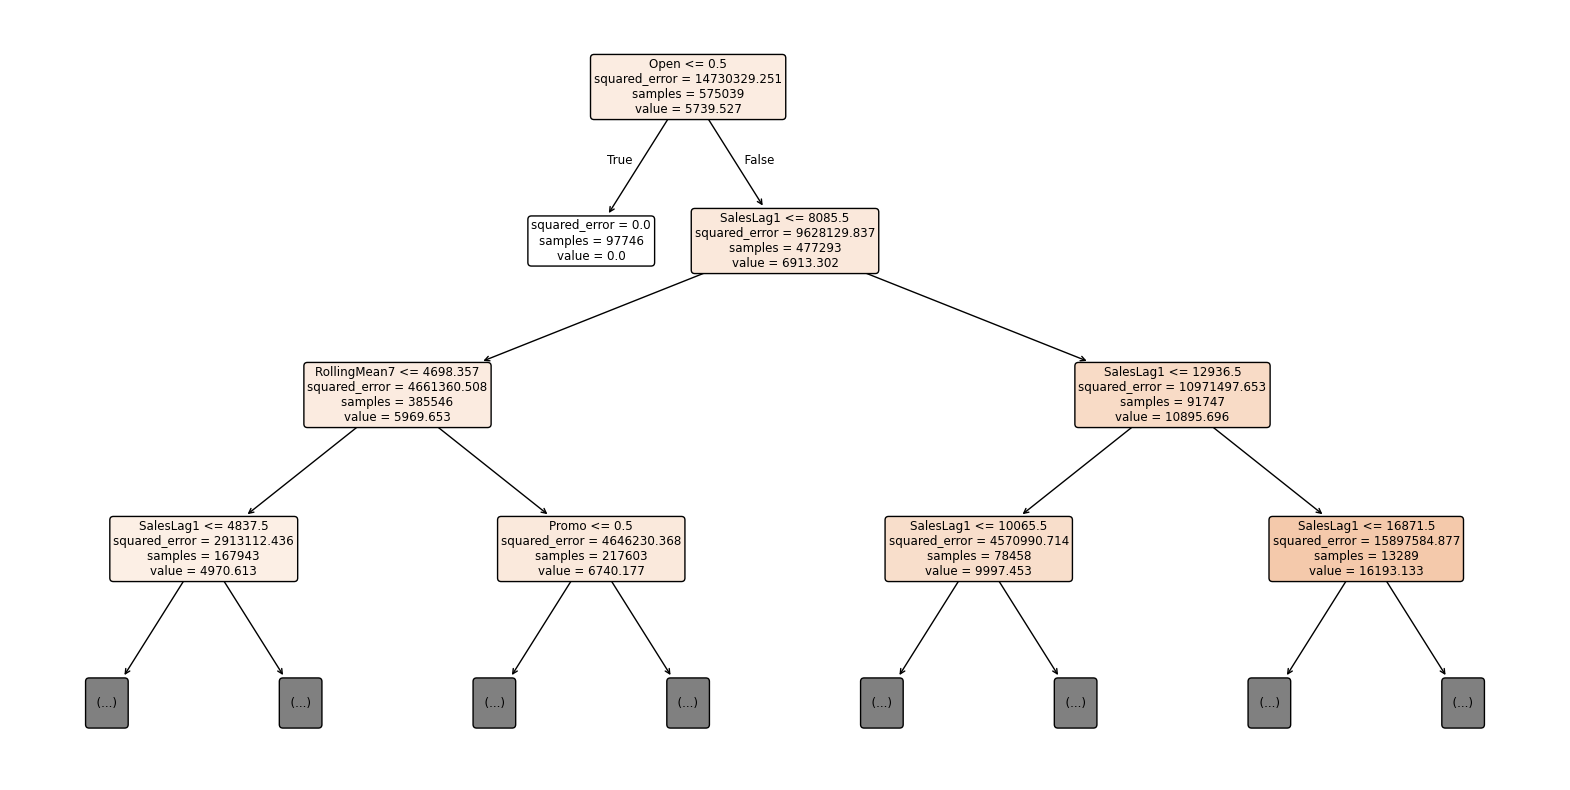

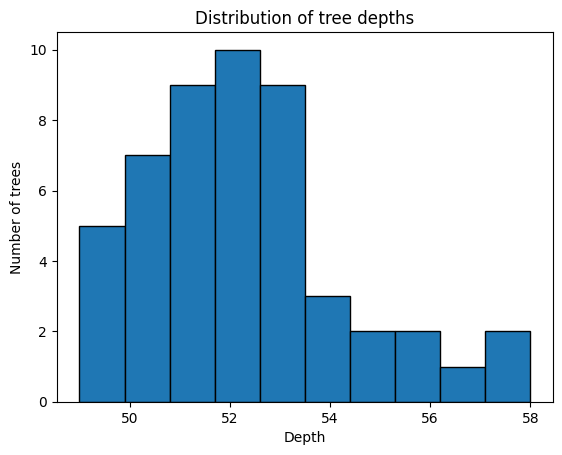

In [ ]:
tree = rf.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(tree, 
          feature_names=x_train.columns, 
          filled=True, 
          rounded=True, 
          max_depth=3)  # limit depth for readability
plt.show()

depths = [t.tree_.max_depth for t in rf.estimators_]
plt.hist(depths, bins=10, edgecolor="black")
plt.title("Distribution of tree depths")
plt.xlabel("Depth")
plt.ylabel("Number of trees")
plt.show()

### XGBoost